### Implementing *Extrapolating Quantum Observables with Machine Learning: Inferring Multiple Phase Transitions from Properties of a Single Phase*

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt

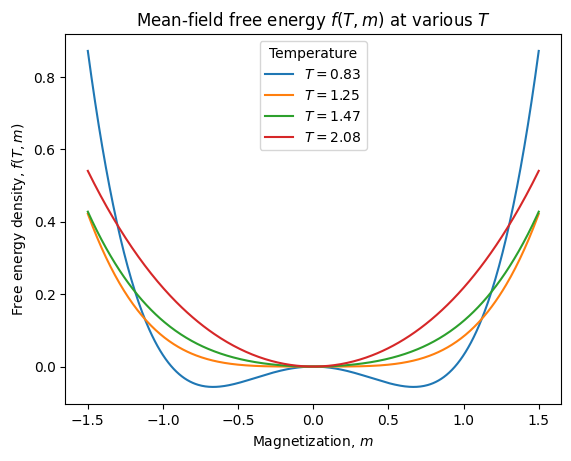

In [4]:
# define free energy density f(T, m) with critical temperature T_c = 1.25
def f(T, m, T_c = 1.25):
    return 0.5 * (1 - T_c / T) * m**2 + (T_c / T)**3 * m**4 / 12

# magnetization range
m = np.linspace(-1.5, 1.5, 500)

# Temperatures to plot
Ts = [0.83, 1.25, 1.47, 2.08]

plt.figure()
for T in Ts:
    plt.plot(m, f(T, m), label = f'$T = {T:.2f}$')
plt.xlabel('Magnetization, $m$')
plt.ylabel('Free energy density, $f(T, m)$')
plt.title('Mean-field free energy $f(T, m)$ at various $T$')
plt.legend(title='Temperature')
plt.show()

In [5]:
# more imports
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct, ConstantKernel
from sklearn.preprocessing import StandardScaler
import itertools

In [6]:
# Setting up for iterative kernel search

# compute BIC, or Bayesion Information Criterion for a fitted GP
def compute_bic(gp: GaussianProcessRegressor, X: np.ndarray, y: np.ndarray) -> float:
    n = X.shape[0]
    log_likelihood = gp.log_marginal_likelihood(gp.kernel_.theta)
    kernel_params = gp.kernel_.theta.shape[0]
    bic = log_likelihood - 0.5 * kernel_params * np.log(n)
    return bic

# Base kernels
base_kernels = {
    'LIN': ConstantKernel(1.0) * DotProduct(),
    'RBF': ConstantKernel(1.0) * RBF(length_scale = 1.0),
    'MAT': ConstantKernel(1.0) * Matern(length_scale = 1.0, nu = 2.5),
    'RQ': ConstantKernel(1.0) * RationalQuadratic(length_scale = 1.0, alpha = 1.0)
}

In [7]:
# implement iterative kernel search to find the optimal kernel combination
def iterative_kernel_search(X: np.ndarray, y: np.ndarray, max_iter: int=10):
    bic_scores = {}
    for name, kernel in base_kernels.items():
        gp = GaussianProcessRegressor(kernel=kernel, normalize_y = True)
        gp.fit(X, y)
        bic_scores[name] = compute_bic(gp, X, y)
    best_name = max(bic_scores, key = bic_scores.get)
    best_kernel = base_kernels[best_name]
    best_bic = bic_scores[best_name]
    history = [(best_name, best_bic)]
    
    for _ in range(max_iter):
        candidates = {}
        for name, kernel in base_kernels.items():
            if name == best_name:
                continue
            for op, combo_k in [('+', best_kernel + kernel), ('*', best_kernel * kernel)]:
                combo_name = f"{best_name}{op}{name}"
                gp = GaussianProcessRegressor(kernel = combo_k, normalize_y = True)
                gp.fit(X, y)
                bic_val = compute_bic(gp, X, y)
                candidates[combo_name] = (bic_val, combo_k)
        combo_name, (combo_bic, combo_k) = max(candidates.items(), key= lambda item: item[1][0])
        if combo_bic > best_bic:
            best_name = combo_name
            best_kernel = combo_k
            best_bic = combo_bic
            history.append((best_name, best_bic))
        else:
            break
    return best_kernel, history

In [8]:
# number of samples
N = 330

# the figure uses 330 random points uniformly from {1.47 < T < 2.08} x {-1.25 < m < 1.25}
T_train = np.random.uniform(low = 1.47, high = 2.08, size = N)
m_train = np.random.uniform(low = -1.25, high = 1.25, size = N)

# compute training outputs
y_train = f(T_train, m_train)
X_train = np.vstack([T_train, m_train]).T
scaler = StandardScaler().fit(X_train)     
X_train_scaled = scaler.transform(X_train)

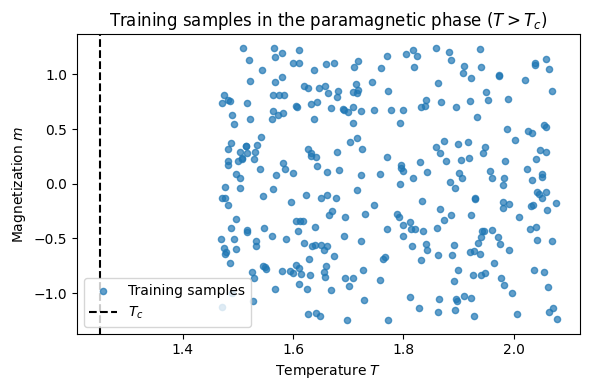

In [9]:
# visualize the training region
plt.figure(figsize=(6, 4))
plt.scatter(T_train, m_train, s=20, alpha=0.7, label='Training samples')
plt.axvline(1.25, color='k', linestyle='--', label='$T_c$')
plt.xlabel('Temperature $T$')
plt.ylabel('Magnetization $m$')
plt.title('Training samples in the paramagnetic phase ($T > T_c$)')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
best_kernel, history = iterative_kernel_search(X_train, y_train)

C:\Users\xinyw\apps\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\xinyw\apps\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\xinyw\apps\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/sta

In [11]:
gp_final = GaussianProcessRegressor(kernel=best_kernel, normalize_y=True)
gp_final.fit(X_train, y_train)

C:\Users\xinyw\apps\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1), normalize_y=True)

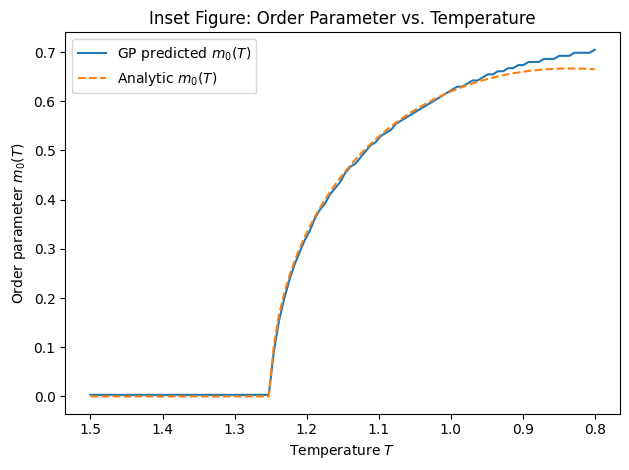

In [12]:
# Extract order parameter m0(T) by grid search
T_vals = np.linspace(1.5, 0.8, 100)
m_vals = np.linspace(-1.25, 1.25, 400)
m0_pred = []
for T in T_vals:
    X_test = np.vstack([np.full_like(m_vals, T), m_vals]).T
    f_pred = gp_final.predict(X_test)
    m0_pred.append(np.abs(m_vals[np.argmin(f_pred)]))
m0_pred = np.array(m0_pred)

# Analytic solution for comparison
Tc = 1.25
m0_analytic = np.sqrt(np.clip(-3 * (1 - Tc / T_vals) / ((Tc / T_vals)**3), 0, None))

# Plot inset figure
plt.figure()
plt.plot(T_vals, m0_pred, label='GP predicted $m_0(T)$')
plt.plot(T_vals, m0_analytic, '--', label='Analytic $m_0(T)$')
plt.legend(loc = 'best')
plt.xlabel('Temperature $T$')
plt.ylabel('Order parameter $m_0(T)$')
plt.title('Inset Figure: Order Parameter vs. Temperature')
plt.tight_layout()
plt.gca().invert_xaxis()
plt.show()

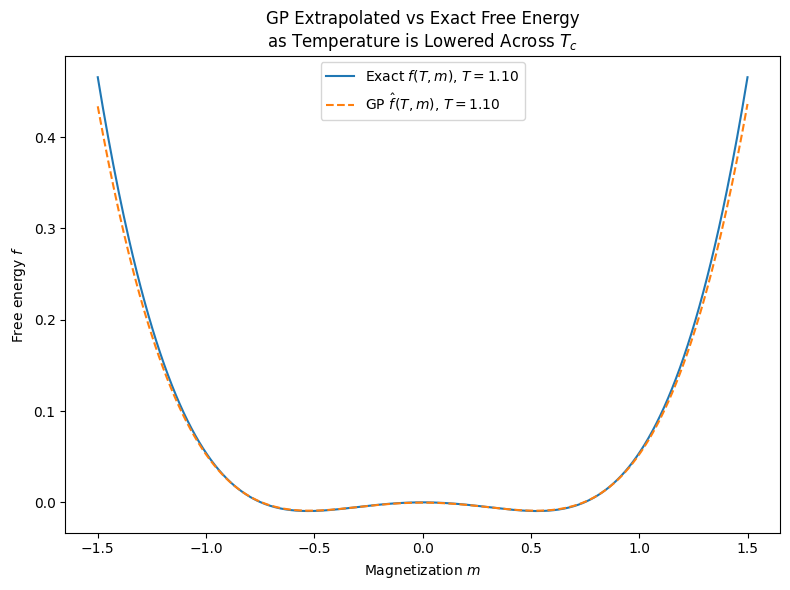

In [18]:
# Plotting the extrapolated mean free-energy as T is lowered. 
T = 1.1

m_vals = np.linspace(-1.5, 1.5, 500)

plt.figure(figsize=(8,6))

X_test = np.vstack([np.full_like(m_vals, T), m_vals]).T
f_pred = gp_final.predict(X_test)
f_true = f(T, m_vals)
plt.plot(m_vals, f_true, label=f'Exact $f(T, m)$, $T = {T:.2f}$')
plt.plot(m_vals, f_pred, '--', label=f'GP $\\hat f(T, m)$, $T = {T:.2f}$')

plt.xlabel('Magnetization $m$')
plt.ylabel('Free energy $f$')
plt.title('GP Extrapolated vs Exact Free Energy\nas Temperature is Lowered Across $T_c$')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

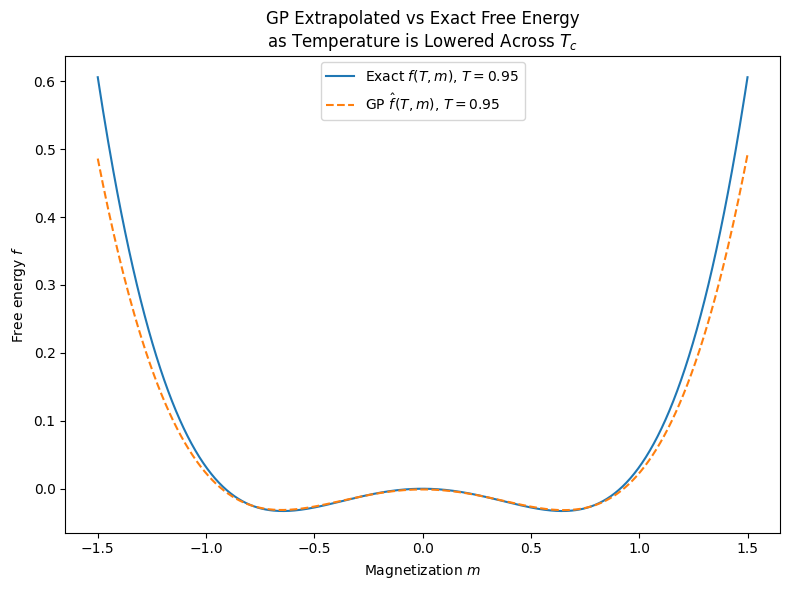

In [19]:
# Plotting the extrapolated mean free-energy as T is lowered. 
T = 0.95

m_vals = np.linspace(-1.5, 1.5, 500)

plt.figure(figsize=(8,6))

X_test = np.vstack([np.full_like(m_vals, T), m_vals]).T
f_pred = gp_final.predict(X_test)
f_true = f(T, m_vals)
plt.plot(m_vals, f_true, label=f'Exact $f(T, m)$, $T = {T:.2f}$')
plt.plot(m_vals, f_pred, '--', label=f'GP $\\hat f(T, m)$, $T = {T:.2f}$')

plt.xlabel('Magnetization $m$')
plt.ylabel('Free energy $f$')
plt.title('GP Extrapolated vs Exact Free Energy\nas Temperature is Lowered Across $T_c$')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

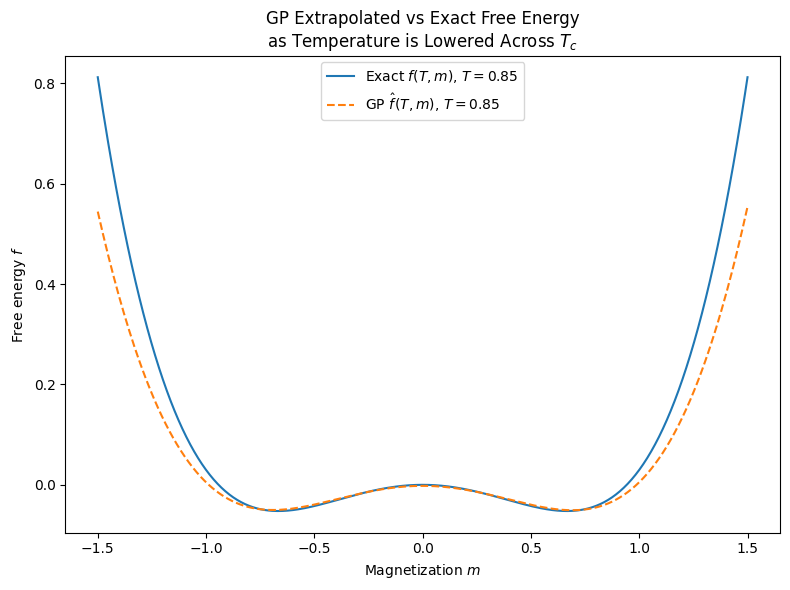

In [20]:
# Plotting the extrapolated mean free-energy as T is lowered. 
T = 0.85

m_vals = np.linspace(-1.5, 1.5, 500)

plt.figure(figsize=(8,6))

X_test = np.vstack([np.full_like(m_vals, T), m_vals]).T
f_pred = gp_final.predict(X_test)
f_true = f(T, m_vals)
plt.plot(m_vals, f_true, label=f'Exact $f(T, m)$, $T = {T:.2f}$')
plt.plot(m_vals, f_pred, '--', label=f'GP $\\hat f(T, m)$, $T = {T:.2f}$')

plt.xlabel('Magnetization $m$')
plt.ylabel('Free energy $f$')
plt.title('GP Extrapolated vs Exact Free Energy\nas Temperature is Lowered Across $T_c$')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

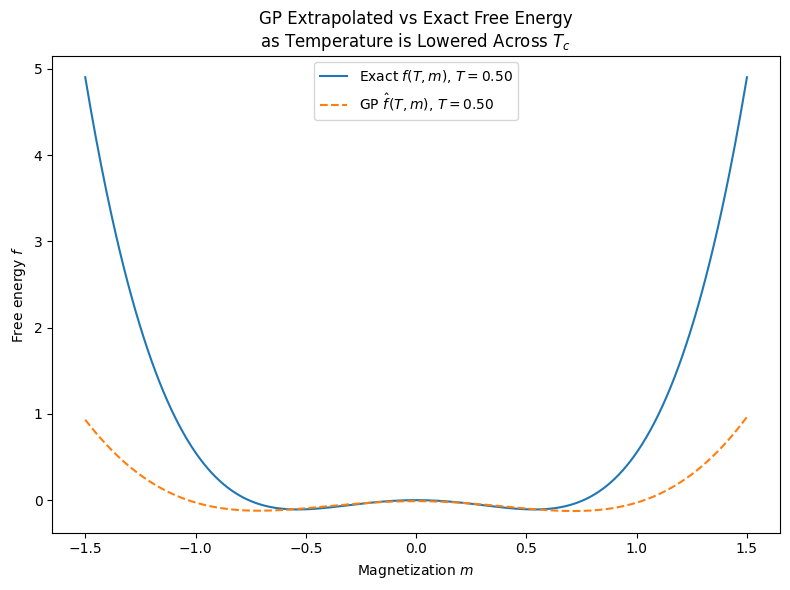

In [21]:
# Plotting the extrapolated mean free-energy as T is lowered. 
T = 0.5

m_vals = np.linspace(-1.5, 1.5, 500)

plt.figure(figsize=(8,6))

X_test = np.vstack([np.full_like(m_vals, T), m_vals]).T
f_pred = gp_final.predict(X_test)
f_true = f(T, m_vals)
plt.plot(m_vals, f_true, label=f'Exact $f(T, m)$, $T = {T:.2f}$')
plt.plot(m_vals, f_pred, '--', label=f'GP $\\hat f(T, m)$, $T = {T:.2f}$')

plt.xlabel('Magnetization $m$')
plt.ylabel('Free energy $f$')
plt.title('GP Extrapolated vs Exact Free Energy\nas Temperature is Lowered Across $T_c$')
plt.legend(loc='best')
plt.tight_layout()
plt.show()